# EOSC 573 - Final Project CTD data processing
### Analysis of Feb 19, 2021 CTD data

In [1]:
import scipy.io as spio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import GSHHSFeature

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [3]:
CTD = loadmat('RBRfeb192021_bin50.mat')['R1p3']['data'];

In [4]:
#column of values that each data type is in
temp = 1
press = 8
seadepth = 3
salinity = 4

In [5]:
#loop to remove rows with NaN
for i in range(len(CTD)):
    CTD[i].values = CTD[i].values[~np.isnan(CTD[i].values).any(axis=1)]

In [6]:
#remove all up-cast rows (preprocessing only done on down-cast for some reason)
r = [i for i in range(len(CTD)) if CTD[i].direction == 'down']
CTD=CTD[r]

(7.0, 8.5, 55.0, -3.0)

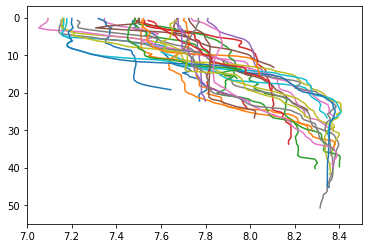

In [7]:
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,temp], CTD[i].values[:,press])
plt.axis([7,8.5,55,-3])

(25.0, 30.0, 55.0, -3.0)

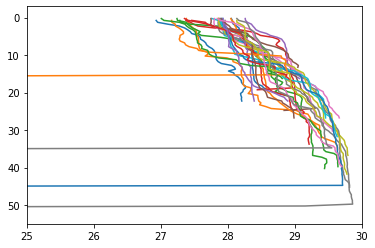

In [8]:
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,salinity], CTD[i].values[:,press])
plt.axis([25,30,55,-3])

cutting out the NaN was clraely not enough to get rid of the weird values here! try again

In [9]:
for i in range(len(CTD)):
    for j in range(len(CTD[i].values)-1):
        if CTD[i].values[j,salinity]-CTD[i].values[j+1,salinity] >0.5:
            print(i, end =",")

17,17,20,21,23,27,

In [10]:
#the amount that each of those needs to be trimmed by is equal to the amount of times they are repeated in that list

#make sure to only run this cell once! trimming the wonky values off the end
#CTD[5].values = CTD[5].values[:-1,:]
CTD[17].values = CTD[17].values[:-2,:]
CTD[20].values = CTD[20].values[:-1,:]
CTD[21].values = CTD[21].values[:-1,:]
CTD[23].values = CTD[23].values[:-1,:]
CTD[27].values = CTD[27].values[:-1,:]

(25.0, 30.0, 55.0, -3.0)

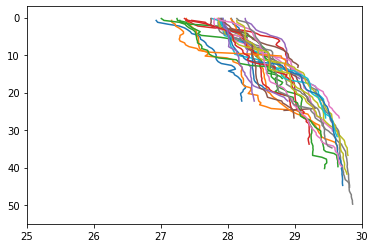

In [11]:
#plot salinity again to see if it looks ok
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,salinity], CTD[i].values[:,press])
plt.axis([25,30,55,-3])

In [12]:
#think its a good idea now to remove some of the data we're going to be using a lot from this complicated struct
# as a pandas dataframe so its easy to look at
d = {'station': [CTD[i].station for i in range(len(CTD))], 
     'lat': [CTD[i].latitude for i in range(len(CTD))],
     'lon': [CTD[i].longitude for i in range(len(CTD))],
     'depth': [CTD[i].depth for i in range(len(CTD))],
     'data': [CTD[i].values for i in range(len(CTD))]}
df = pd.DataFrame(data=d)
df;

In [13]:
# may evenbe nice to make it into a really long dataframe so the stuff in the data column can be visible too
# and its easier to make contour plot
length = sum([len(df.data[i]) for i in range(len(df))])
tr = {'transect': np.empty(length, dtype=object),
     'station': np.empty(length, dtype=object), 
     'lat': np.zeros(length),
     'lon': np.zeros(length),
     'depth': np.zeros(length),
     'temperature': np.zeros(length),
     'salinity': np.zeros(length),
     'pressure':np.zeros(length),
     'seadepth': np.zeros(length)}

a=0
for i in range(len(df)):
    if i>0:
        a += len(df.data[i-1])
        
    for j in range(len(df.data[i])):
        tr['transect'][j+a] = df.station[i][:-2]
        tr['station'][j+a] = df.station[i][-2:]
        tr['lat'][j+a] = df.lat[i]
        tr['lon'][j+a] = df.lon[i]
        tr['depth'][j+a] = df.depth[i]
        tr['temperature'][j+a] = df.data[i][j,temp]
        tr['salinity'][j+a] = df.data[i][j,salinity]
        tr['seadepth'][j+a] = df.data[i][j,seadepth]
        tr['pressure'][j+a] = df.data[i][j,press]
        
all_tr = pd.DataFrame(data=tr)
all_tr;

In [14]:
#save the pd.dataframe as a csv and do the rest of the processing in another tile
#(no need to reload and reprocess the struct over and over again)

#export df - better for surface plots and mapping
#df.to_csv('CTDsurface.csv')
#export all_tr - better for cross sections
all_tr.to_csv('CTDcrosssection.csv')

In [15]:
#the df didnt export properly to a csv because of how the arrays are setup in the data column
#easiest fix is just not to export it and to find seperation between each transect here and bring these numbers into the other notebook

#lets find the speration indext between each transect, defined as the index of the first value in each transect
tr1 = 0
tr2 = sum([len(df.data[i]) for i in range(5)])
tr3 = sum([len(df.data[i]) for i in range(10)])
tr4 = sum([len(df.data[i]) for i in range(15)])
tr5 = sum([len(df.data[i]) for i in range(21)])
tr2b = sum([len(df.data[i]) for i in range(24)])
print(str(tr1)+','+str(tr2)+','+str(tr3)+','+str(tr4)+','+str(tr5)+','+str(tr2b))

0,286,615,897,1315,1415


### mapping

In [16]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    return fig, ax

In [17]:
central_lon, central_lat = -123.2, 49.3
extent = [-123.28, -123.13, 49.35, 49.25]

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


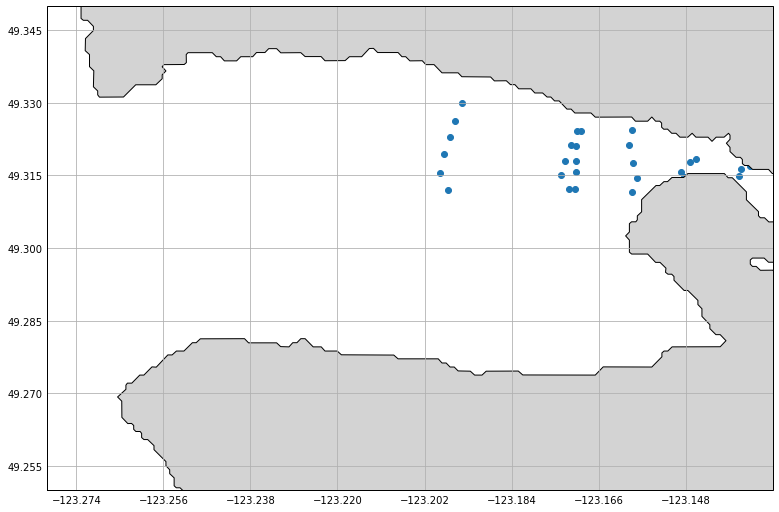

In [18]:
coast = GSHHSFeature(scale='full')

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent(extent)
feature = ax.add_feature(coast, edgecolor='black', facecolor='lightgray')

#plot stations with labels
plt.scatter(df.lon, df.lat)